<a href="https://colab.research.google.com/github/jamestheengineer/data-science-from-scratch-Python/blob/master/Chapter_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only do this once per VM, otherwise you'll get multiple clones and nested directories
!git clone https://github.com/jamestheengineer/data-science-from-scratch-Python.git
%cd data-science-from-scratch-Python/
!pip install import-ipynb
import import_ipynb

Cloning into 'data-science-from-scratch-Python'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 465 (delta 50), reused 0 (delta 0), pack-reused 387
Receiving objects: 100% (465/465), 1.14 MiB | 1.30 MiB/s, done.
Resolving deltas: 100% (290/290), done.
/content/data-science-from-scratch-Python
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=65eb32e3e5aa84498521f349202f9f727c4f4c73181db436f308a0c3b97d38da
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
# Deep learning chapter

Tensor = list

from typing import List

def shape(tensor: Tensor) -> List[int]:
  sizes: List[int] = []
  while isinstance(tensor, list):
    sizes.append(len(tensor))
    tensor = tensor[0]
  return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]


In [3]:
def is_1d(tensor: Tensor) -> bool:
  """
  If tensor[0] is a list, it's a higher-order tensor.
  Otherwise, tensor is 1-dimensional (that is, a vector)
  """
  return not isinstance(tensor[0], list)

assert is_1d([1,2,3])
assert not is_1d([[1,2],[3,4]])

In [4]:
def tensor_sum(tensor: Tensor) -> float:
  """Sums up all the values in the tensor"""
  if is_1d(tensor):
    return sum(tensor) # just a list of floats, use Python sum
  else:
    return sum(tensor_sum(tensor_i) # Call tensor_sum on each row
               for tensor_i in tensor) # and sum up those results

assert tensor_sum([1,2,3]) == 6
assert tensor_sum([[1,2],[3,4]]) == 10

In [5]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
  """Applies f elementwise"""
  if is_1d(tensor):
    return [f(x) for x in tensor]
  else:
    return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x+1, [1, 2, 3]) == [2,3,4]
assert tensor_apply(lambda x: 2 * x, [[1,2],[3,4]]) == [[2,4],[6,8]]

In [6]:
def zeros_like(tensor: Tensor) -> Tensor:
  return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1,2,3]) == [0,0,0]
assert zeros_like([[1,2],[3,4]]) == [[0,0],[0,0]]

In [7]:
def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
      return [f(x,y) for x, y in zip(t1,t2)]
    else:
      return [tensor_combine(f, t1_i, t2_i)
              for t1_i, t2_i in zip(t1, t2)]

import operator

assert tensor_combine(operator.add, [1,2,3],[4,5,6]) == [5,7,9]
assert tensor_combine(operator.mul, [1,2,3], [4,5,6]) == [4,10,18]

In [8]:
from typing import Iterable, Tuple

class Layer:
  """
  Our neural networks will be composed of layers, each of which
  knows how to do some computation on its inputs in the "forward"
  direction and propagate gradients in the "backward" direction.
  """
  def backward(self, gradient):
    """
    Similarly, we're not going to be prescriptive about what the
    gradient looks like. It's up to you the user to make sure 
    that you're doing things sensibly.
    """
    raise NotImplementedError
  
  def params(self) -> Iterable[Tensor]:
    """
    Returns the parameters of this layer. The default implementation 
    returns nothing, so that if you have a layer with no parameters
    you don't have to implement this.
    """
    return ()

  def grads(self) -> Iterable[Tensor]:
    """
    Returns the gradients, in the smae order as params().
    """
    return ()

In [9]:
from Chapter_18 import sigmoid

class Sigmoid(Layer):
  def forward(self, input: Tensor) -> Tensor:
    """
    Apply sigmoid to each element of the input tensor,
    and save the results to use in backpropagation.
    """
    self.sigmoids = tensor_apply(sigmoid, input)
    return self.sigmoids

  def backward(self, gradient: Tensor) -> Tensor:
    return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                          self.sigmoids,
                          gradient)

importing Jupyter notebook from Chapter_18.ipynb
importing Jupyter notebook from Chapter_04.ipynb
1 1 1
1 / 100
2 2 2
2 / 100
3 3 fizz
2 / 100
4 fizzbuzz 4
2 / 100
5 5 buzz
2 / 100
6 fizzbuzz fizz
2 / 100
7 7 7
3 / 100
8 buzz 8
3 / 100
9 buzz fizz
3 / 100
10 10 buzz
3 / 100
11 buzz 11
3 / 100
12 fizzbuzz fizz
3 / 100
13 13 13
4 / 100
14 14 14
5 / 100
15 15 fizzbuzz
5 / 100
16 16 16
6 / 100
17 17 17
7 / 100
18 18 fizz
7 / 100
19 19 19
8 / 100
20 20 buzz
8 / 100
21 21 fizz
8 / 100
22 22 22
9 / 100
23 23 23
10 / 100
24 24 fizz
10 / 100
25 25 buzz
10 / 100
26 26 26
11 / 100
27 27 fizz
11 / 100
28 28 28
12 / 100
29 29 29
13 / 100
30 30 fizzbuzz
13 / 100
31 31 31
14 / 100
32 32 32
15 / 100
33 33 fizz
15 / 100
34 34 34
16 / 100
35 35 buzz
16 / 100
36 36 fizz
16 / 100
37 37 37
17 / 100
38 38 38
18 / 100
39 39 fizz
18 / 100
40 40 buzz
18 / 100
41 41 41
19 / 100
42 42 fizz
19 / 100
43 43 43
20 / 100
44 44 44
21 / 100
45 45 fizzbuzz
21 / 100
46 46 46
22 / 100
47 47 47
23 / 100
48 48 fizz
23 / 100

importing Jupyter notebook from Chapter_06.ipynb
P(both | older): 0.5007089325501317
P(both | either): 0.3311897106109325


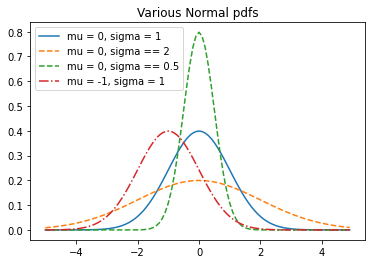

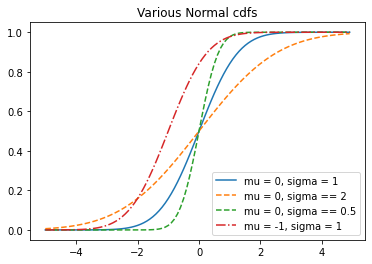

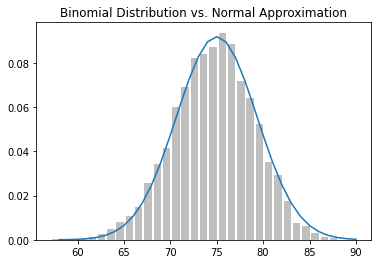

In [10]:
# Functions to randomly generate our weight tensors
import random

from Chapter_06 import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
  if len(dims) == 1:
    return [random.random() for _ in range(dims[0])]
  else:
    return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 1.0,
                  variance: float = 1.0) -> Tensor:
  if len(dims) == 1:
    return [mean + variance * inverse_normal_cdf(random.random())
            for _ in range(dims[0])]
  else:
    return [random_normal(*dims[1:], mean=mean, variance=variance)
            for _ in range(dims[0])]

assert shape(random_uniform(2,3,4)) == [2,3,4]
assert shape(random_normal(5,6,mean=10)) == [5,6]

In [11]:
# Wrap them all in a random_tensor function

def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
  if init == 'normal':
    return random_normal(*dims)
  elif init == 'uniform':
    return random_uniform(*dims)
  elif init == 'xavier':
    variance = len(dims) / sum(dims)
    return random_normal(*dims, variance=variance)
  else:
    raise ValueError(f"unknown init: {init}")

In [12]:
# Define the linear layer
from Chapter_04 import dot

class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

In [13]:
# Define a sequence of layers
from typing import List

class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())


In [14]:
# But we still need to train it, so more classes to write

class Loss:
  def loss(self, predicted: Tensor, actual: Tensor) -> float:
    """How good are out predictions? (Larger numbers are worse.)"""
    raise NotImplementedError
  
  def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
    """How does the loss change as the predictions change?"""
    raise NotImplementedError

class SSE(Loss):
  """Loss function that computes the sum of the squared errors."""
  def loss(self, predicted: Tensor, actual: Tensor) -> float:
    # Compute the tensor of squared differences
    squared_errors = tensor_combine(
                      lambda predicted, actual: (predicted - actual) ** 2,
                      predicted,
                      actual)
    # And just add them up
    return tensor_sum(squared_errors)

  def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
    return tensor_combine(
        lambda predicted, actual: 2 * (predicted - actual),
        predicted,
        actual)

sse_loss = SSE()
assert sse_loss.loss([1, 2, 3], [10, 20, 30]) == 9 ** 2 + 18 ** 2 + 27 ** 2
assert sse_loss.gradient([1, 2, 3], [10, 20, 30]) == [-18, -36, -54]


In [15]:
# Need an absract optimizer so we can create different variants of gradient descent

class Optimizer:
  """
  An optimizer updates the weights of a layer (in place) using information
  known by either the layer or the optimizer (or by both).
  """
  def step(self, layer: Layer) -> None:
    raise NotImplementedError
  
class GradientDescent(Optimizer):
  def __init__(self, learning_rate: float = 0.1) -> None:
    self.lr = learning_rate
  
  def step(self, layer: Layer) -> None:
    for param, grad in zip(layer.params(), layer.grads()):
      # Update param using a gradient step
      param[:] = tensor_combine(
          lambda param, grad: param - grad * self.lr,
          param,
          grad)

# Note the slice operator. You have to use this if you want to affect the original list. For example
tensor = [[1,2],[3,4]]

for row in tensor:
  row = [0,0]
assert tensor == [[1,2],[3,4]], "assignment doesn't update a list"

for row in tensor:
  row[:] = [0,0]
assert tensor == [[0,0], [0,0]], "but slice assignment does"


In [16]:
# Let's show the flexibility of this design by implmenting one more optimizer

class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

In [19]:
# Let's revisit XOR

# training data
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

random.seed(0)

net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=2, output_dim=1)
])

import tqdm

optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()

with tqdm.trange(3000) as t:
    for epoch in t:
        epoch_loss = 0.0

        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)

            optimizer.step(net)

        t.set_description(f"xor loss {epoch_loss:.3f}")

for param in net.params():
    print(param)

xor loss 0.000: 100%|██████████| 3000/3000 [00:04<00:00, 637.62it/s]

[[3.5554992459094508, 3.2301163068668624], [1.5628401808174888, 1.4874326472741894]]
[-0.6445062004781298, -2.1460068733214146]
[[3.0189389298298797, -3.250177891119526]]
[-0.6988954441245024]


In [20]:
# One replacement for sigmoid is tanh

import math

def tanh(x: float) -> float:
  # If x is very large or very small, tanh is (essentially) 1 or -1.
  # We check for this because, e.g., math.exp(1000) raises an error.
  if x < -100: return -1
  elif x > 100: return 1

  em2x = math.exp(-2 * x)
  return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
  def forward(self, input: Tensor) -> Tensor:
    # Save tanh output to use in backward pass.
    self.tanh = tensor_apply(tanh, input)
    return self.tanh

  def backward(self, gradient: Tensor) -> Tensor:
    return tensor_combine(
        lambda tanh, grad: (1 - tanh ** 2) * grad,
        self.tanh,
        gradient)

In [21]:
# Another popular one is relu

class Relu(Layer):
  def forward(self, input: Tensor) -> Tensor:
    self.input = input
    return tensor_apply(lambda x: max(x, 0), input)

  def backward(self, gradient: Tensor) -> Tensor:
    return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                          self.input,
                          gradient)

In [24]:
# Fizzbuzz revisted

from Chapter_18 import binary_encode, fizz_buzz_encode, argmax

xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

NUM_HIDDEN = 25

random.seed(0)

def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
  num_correct = 0
  for n in range(low, hi):
    x = binary_encode(n)
    predicted = argmax(net.forward(x))
    actual = argmax(fizz_buzz_encode(n))
    if predicted == actual:
      num_correct += 1

  return num_correct / (hi - low)

In [ ]:
net = Sequential([
                  Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
                  Tanh(),
                  Linear(input_dim=NUM_HIDDEN, output_dim=4, init="uniform"),
                  Sigmoid()
])

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SSE()

with tqdm.trange(1000) as t:
  for epoch in t:
    epoch_loss = 0.0

    for x, y in zip(xs, ys):
      predicted = net.forward(x)
      epoch_loss += loss.loss(predicted, y)
      gradient = loss.gradient(predicted, y)
      net.backward(gradient)

      optimizer.step(net)
    
    accuracy = fizzbuzz_accuracy(101, 1024, net)
    t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")

# Now check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))

In [23]:
def softmax(tensor: Tensor) -> Tensor:
  """Softmad along the last dimension"""
  if is_1d(tensor):
    # Subtract the largest value for numerical stability.
    largest = max(tensor)
    exps = [math.exp(x - largest) for x in tensor]

    sum_of_exps = sum(exps)  # This is the total "weight"
    return [exp_i / sum_of_exps # Probability is the fraction
            for exp_i in exps] # of the total weight
  else:
    return [softmax(tensor_i) for tensor_i in tensor]

class SoftmaxCrossEntropy(Loss):
  """
  This is the negative-log-likelihood of the ovserved values, given the
  neural net model. So if we choose weights ot minimize it, out model will
  be maximinzing the likelihood of the observed data.
  """
  def loss(self, predicted: Tensor, actual: Tensor) -> float:
    # Apply softmax to get probabilities
    probabilities = softmax(predicted)

    # This will be log p_i for the actual class i and 0 for the other
    # classes. We add a tiny amount to p to avoid taking log(0).
    likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                 probabilities,
                                 actual)
    
    # And then we just sum up the negatives.
    return -tensor_sum(likelihoods)

  def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
    probabilities = softmax(predicted)

    # Isn't this a pleasant equation:
    return tensor_combine(lambda p, actual: p - actual,
                          probabilities,
                          actual)

In [25]:
net = Sequential([
                  Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
                  Tanh(),
                  Linear(input_dim=NUM_HIDDEN, output_dim=4, init="uniform"),
                  # No final Sigmoid layer now
])

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()

with tqdm.trange(1000) as t:
  for epoch in t:
    epoch_loss = 0.0

    for x, y in zip(xs, ys):
      predicted = net.forward(x)
      epoch_loss += loss.loss(predicted, y)
      gradient = loss.gradient(predicted, y)
      net.backward(gradient)

      optimizer.step(net)
    
    accuracy = fizzbuzz_accuracy(101, 1024, net)
    t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")

# Now check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))


fb loss: 2.56 acc: 1.00:  14%|█▎        | 137/1000 [01:07<07:06,  2.02it/s]


KeyboardInterrupt: ignored

In [26]:
# Dropout is another method, like regularization, to avoid over fitting data

class Dropout(Layer):
  def __init__(self, p: float) -> None:
    self.p = p
    self.train = True

  def forward(self, input: Tensor) -> Tensor:
    if self.train:
      # Create a mask of 0s and 1s shaped like the input
      # using the specified proabability
      self.mask = tensor_apply(
          lambda _: 0 if random.random() < self.p else 1,
          input)
      # Mulitple by the mask to dropout inputs
      return tensor_combine(operator.mul, input, self.mask)
    else:
      # During evaluation just scale down the outputs uniformly.
      return tensor_apply(lambda x: x * (1 - selp.p), input)
  
  def backward(self, gradient: Tensor) -> Tensor:
    if self.train:
      # Only propagate the gradients where mask == 1
      return tensor_combine(operator.mul, gradient, self.mask)
    else:
      raise RunTimeError("don't call backward when not in train mode")
      

In [27]:
# MNIST example
!pip install mnist

In [28]:
import mnist

# This will download the data; change this to where you want it.
# Yes, it's a 0-argument function, that's what the library expects.
# Yes, I'm assigning a lambda to a variable, like I said never to do
!pwd

/content/data-science-from-scratch-Python


In [29]:
mnist.temporary_dir = lambda: '/content/data-science-from-scratch-Python'

# Each of these functions first downloads the data and returns a numpy array
# We call .tolist() because our tensors are just lists
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()

assert shape(train_images) == [60000, 28, 28]
assert shape(train_labels) == [60000]

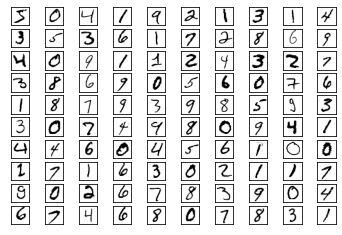

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10,10)

for i in range(10):
  for j in range(10):
    # Plot each image in black and white and hide the axes.
    ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
    ax[i][j].xaxis.set_visible(False)
    ax[i][j].yaxis.set_visible(False)

plt.show()